# Physics Informed Neural Network (PINN) to fit Harmonic Oscillator Data

## Importing libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [3]:
# Spring Mass parameters
m = 1 # kg
k = 1 # N/m
c = 0.1 # Ns/m

w0 = np.sqrt(k/m)
d = c/(2*m)

print("Natural frequency is : " , w0)
print("Damping ratio is : ", d)

Natural frequency is :  1.0
Damping ratio is :  0.05


## Import dataset

In [4]:
import pandas as pd

In [17]:
# Load the CSV file into a DataFrame
train = pd.read_csv('data/completion/train.csv')
test = pd.read_csv('data/completion/test.csv')

# Extract the first column into a numpy array
train_t= train.iloc[:, 0].values
train_x = train.iloc[:, 1].values

test_t= test.iloc[:, 0].values
test_x = test.iloc[:, 1].values

# Convert numpy arrays to PyTorch tensors
train_t = torch.tensor(train_t, dtype=torch.float32).view(-1,1)
train_x = torch.tensor(train_x, dtype=torch.float32).view(-1,1)

test_t = torch.tensor(test_t, dtype=torch.float32).view(-1,1)
test_x = torch.tensor(test_x, dtype=torch.float32).view(-1,1)

In [6]:
print("Length of train data: ", len(train_t))
print("Length of test data: ", len(test_t))

Length of train data:  200
Length of test data:  300


## Plot exact solution

In [7]:
u_exact = exact_solution(d, w0, train_t)

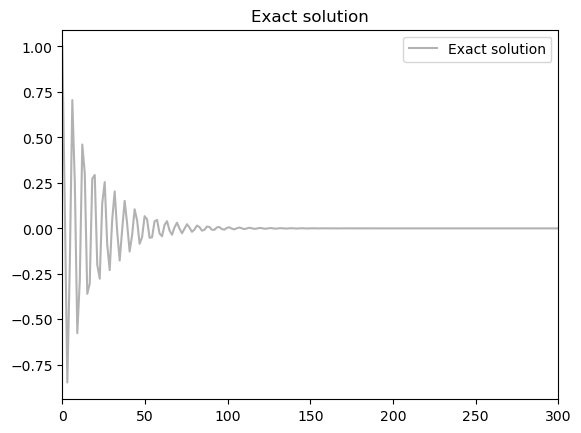

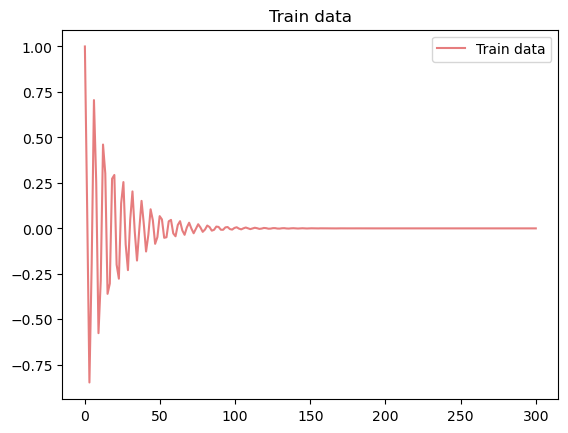

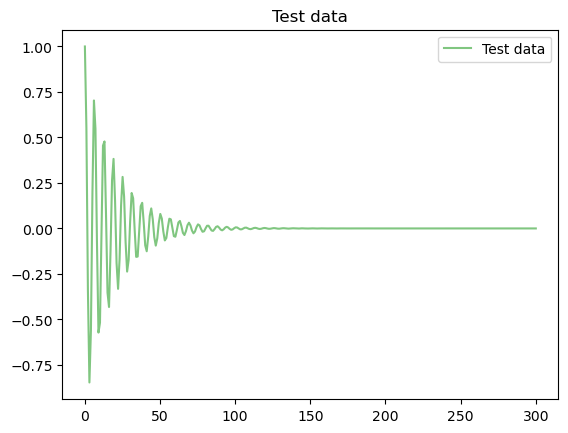

In [10]:
import matplotlib.pyplot as plt

# Plot 1: Exact solution
fig, ax = plt.subplots()
ax.plot(train_t[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
ax.set_title("Exact solution")
ax.legend()
ax.set_xlim(0, 300)

# Plot 2: Train data
fig, ax = plt.subplots()
ax.plot(train_t[:,0], train_x[:,0], label="Train data", color="tab:red", alpha=0.6)
ax.set_title("Train data")
ax.legend()

# Plot 3: Test data
fig, ax = plt.subplots()
ax.plot(test_t[:,0], test_x[:,0], label="Test data", color="tab:green", alpha=0.6)
ax.set_title("Test data")
ax.legend()

plt.show()

## Building Model

In [11]:
class FCN(nn.Module):
    "A fully connected network module"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        
        # Tanh activation function
        activation = nn.Tanh
        
        # Input layer
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        
        # Hidden layers
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        
        # Output layer
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Instantiating model


In [12]:
torch.manual_seed(123)

In [24]:
# Create model instance
pinn = FCN(1, 1, 32, 3)

# For boundary condition (t=0)
t_boundary = torch.tensor(0.0).view(-1, 1).requires_grad_(True)
t_physics = train_t.clone().requires_grad_(True)

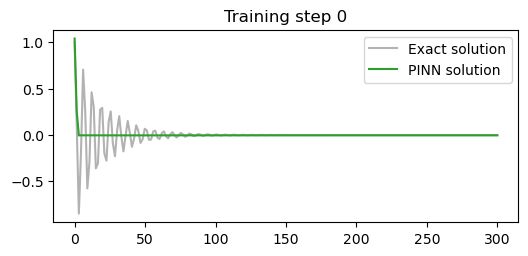

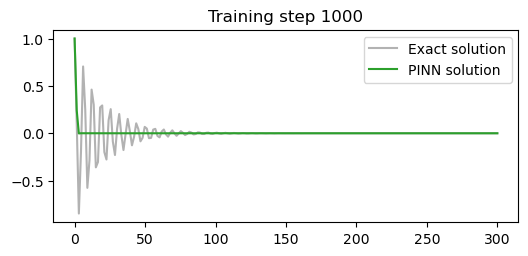

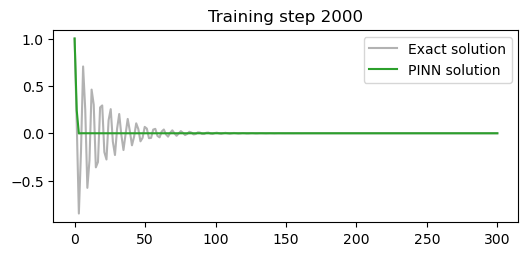

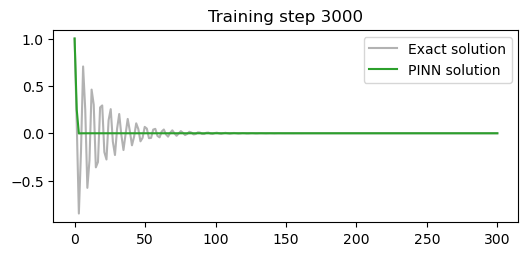

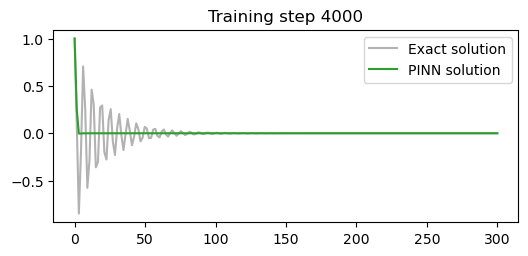

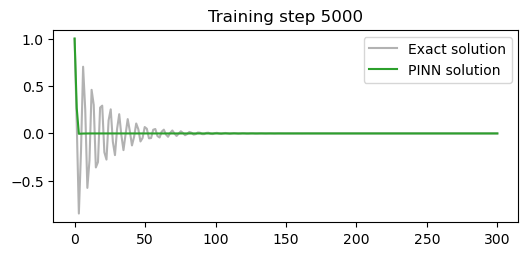

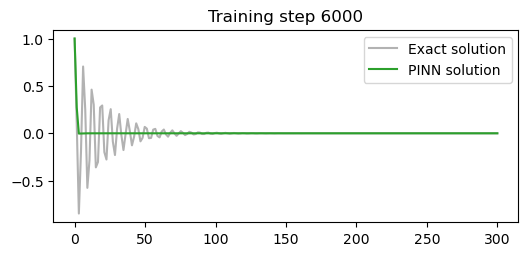

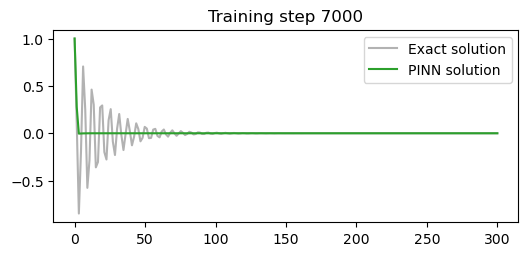

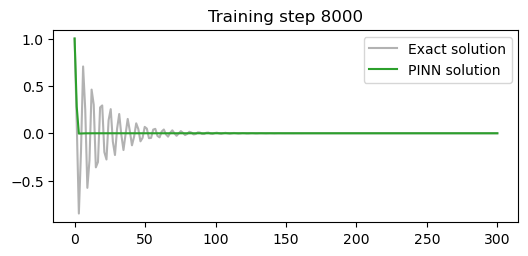

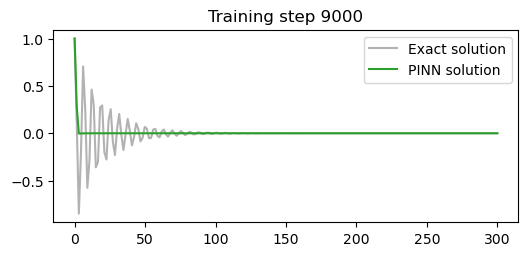

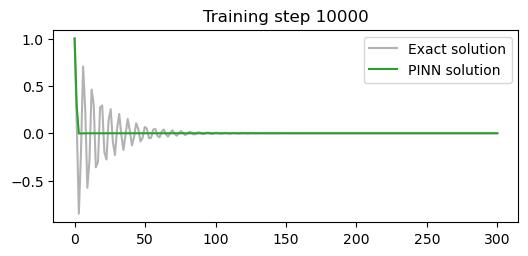

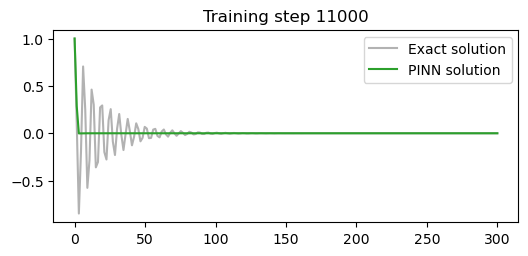

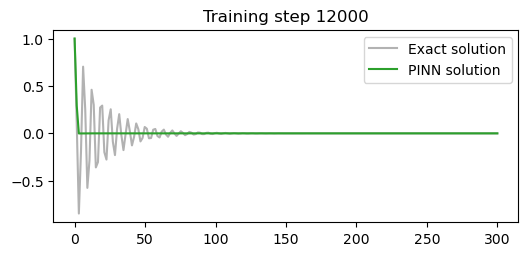

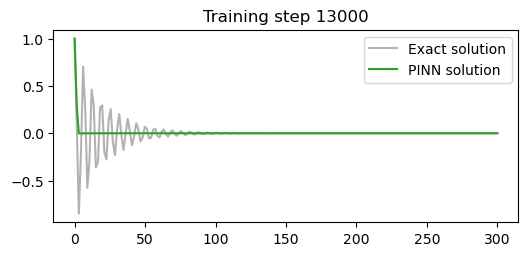

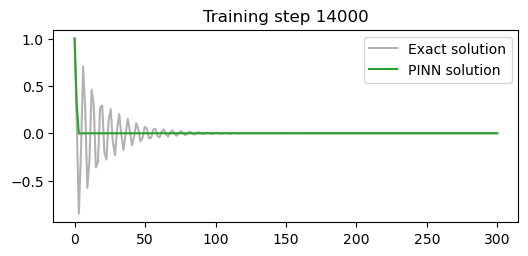

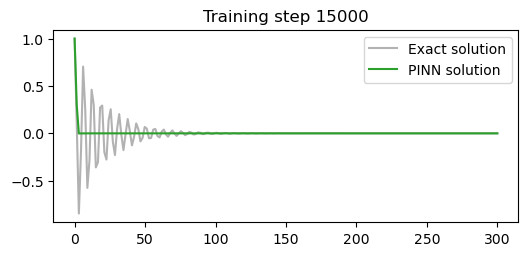

In [34]:
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)

# Training loop
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-2
    
    # compute boundary loss
    # TODO: write code here
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    # TODO: write code here
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + c*dudt + k*u)**2)
    
    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 1000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(train_t).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(train_t[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(train_t[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()